In [1]:
# libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Dropout, TimeDistributed

import warnings

In [2]:
# settings
plt.rcParams['figure.figsize'] = (10,4)
sns.set()
warnings.filterwarnings('ignore')

In [3]:
# importing data
data = pd.read_csv('nyc_taxi.csv', parse_dates=['timestamp'], index_col='timestamp')
data.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


<AxesSubplot:title={'center':'Data points'}, xlabel='timestamp'>

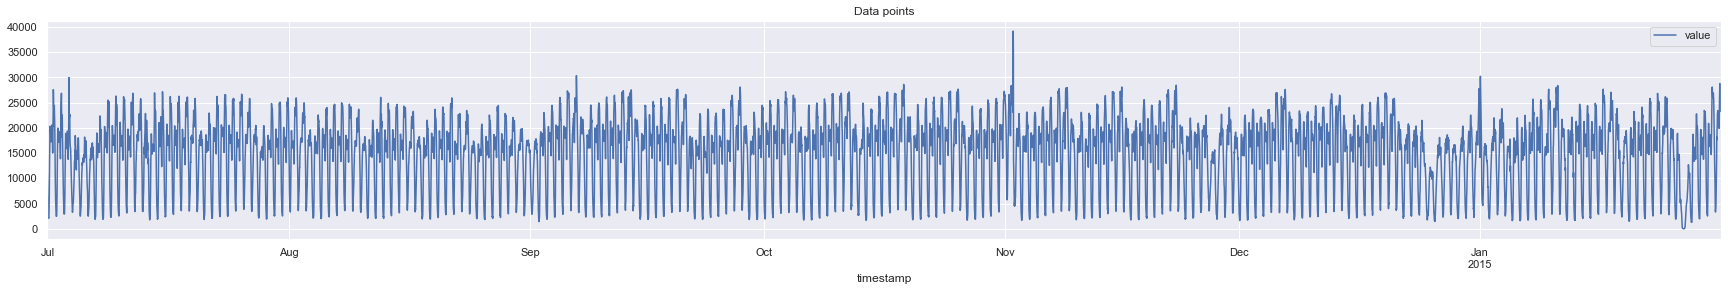

In [4]:
data.plot(title='Data points', figsize=(30,4))

In [5]:
ratio = 0.55

train_size = int(data.shape[0] * ratio)
train = data[:train_size]
test = data[train_size:]

dates_train = data.index[:train_size]
dates_test = data.index[train_size:]

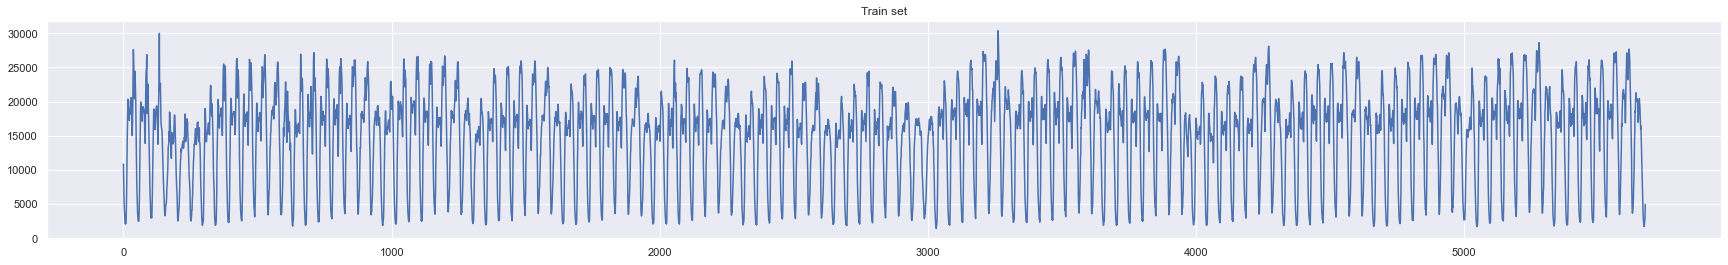

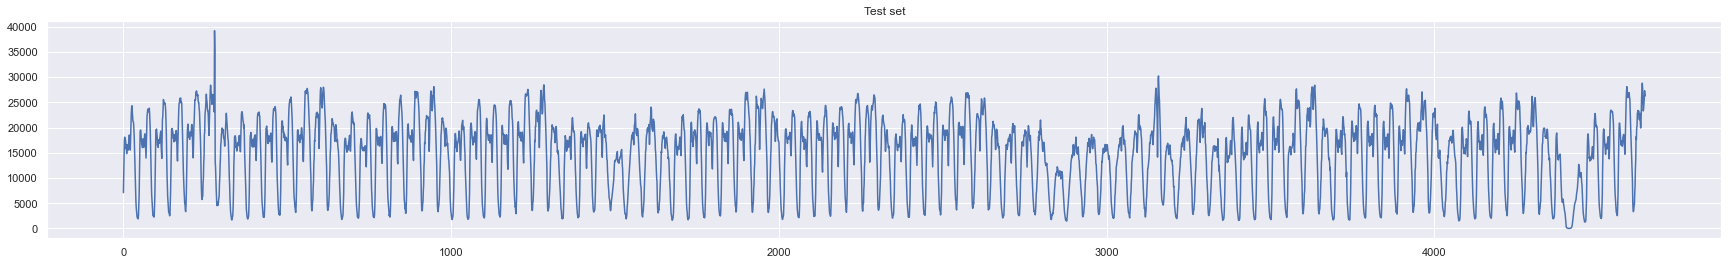

In [6]:
#plots
plt.figure(figsize=(30,4))
plt.title('Train set')
plt.plot(train.to_numpy().flatten())

plt.figure(figsize=(30,4))
plt.title('Test set')
plt.plot(test.to_numpy().flatten())

### Data standardization

In [7]:
scaler = StandardScaler()
scaler = scaler.fit(train.values.reshape(-1, 1))

train = scaler.transform(train.values.reshape(-1, 1))
test = scaler.transform(test.values.reshape(-1, 1))

In [8]:
def split_into_windows(X, length):
    windows = []
    for start in range(0, len(X) - length + 1):
        windows.append(X[start: start + length])
    return np.array(windows)

In [9]:
window_length = 48

X_train = split_into_windows(train, window_length)
X_test = split_into_windows(test, window_length)

_, input_length, input_dim = X_train.shape

In [10]:
X_train.shape

(5629, 48, 1)

In [11]:
# params
dim_hidden1 = 24 # 1/2 the length of one window
dim_hidden2 = 12 # 1/4 the length of one window


# model
model = Sequential()

model.add(LSTM(units=dim_hidden1, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=dim_hidden2, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=dim_hidden2, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=dim_hidden1, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(Dense(1))

# summary
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48, 24)            2496      
_________________________________________________________________
dropout (Dropout)            (None, 48, 24)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 12)            1776      
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 12)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 48, 12)            1200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 12)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 48, 24)            3

### Fitting model

In [12]:
# params
batch_size = 48 # 24 hours == length of the window
epochs = 50
validation_split = 0.1

# fitting
history = model.fit(X_train, X_train, 
                batch_size = batch_size, 
                epochs = epochs, 
                validation_split = validation_split, 
                callbacks = [EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/50
106/106 [==============================] - 20s 125ms/step - loss: 0.7052 - val_loss: 0.4041
Epoch 2/50
106/106 [==============================] - 12s 109ms/step - loss: 0.2867 - val_loss: 0.1780
Epoch 3/50
106/106 [==============================] - 11s 105ms/step - loss: 0.1732 - val_loss: 0.0955
Epoch 4/50
106/106 [==============================] - 11s 100ms/step - loss: 0.1207 - val_loss: 0.0633
Epoch 5/50
106/106 [==============================] - 12s 118ms/step - loss: 0.0944 - val_loss: 0.0459
Epoch 6/50
106/106 [==============================] - 11s 105ms/step - loss: 0.0804 - val_loss: 0.0383
Epoch 7/50
106/106 [==============================] - 13s 119ms/step - loss: 0.0711 - val_loss: 0.0296
Epoch 8/50
106/106 [==============================] - 11s 107ms/step - loss: 0.0650 - val_loss: 0.0270
Epoch 9/50
106/106 [==============================] - 12s 110ms/step - loss: 0.0598 - val_loss: 0.0236
Epoch 10/50
106/106 [==============================] - 13s 126ms/step - l

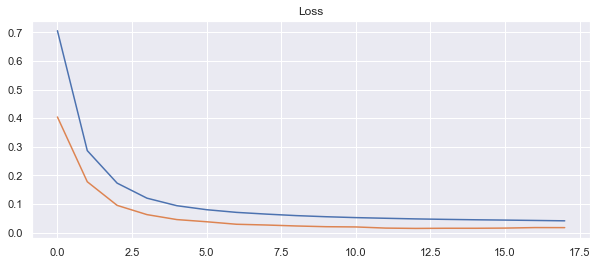

In [13]:
plt.title('Loss')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

### Reconstruction

In [14]:
pred_x_test = model.predict(X_test)
pred_x_train = model.predict(X_train)

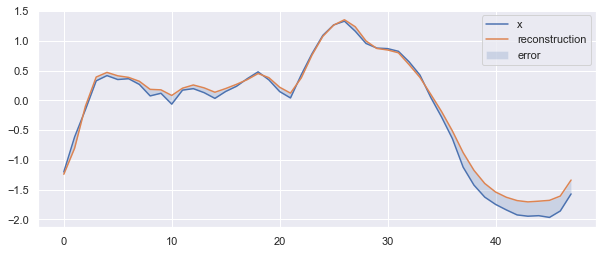

In [19]:
period = 48 # 1 point / 30min -> 48 point / day

for i in range(int(period / window_length)):
    x = X_test[i * window_length].flatten()
    x_pred = pred_x_test[i * window_length].flatten()
    
    plt.plot(x, label='x')
    plt.plot(x_pred, label='reconstruction')
    plt.fill_between(np.arange(window_length), x, x_pred, alpha=0.2, label='error')
    plt.legend()
    plt.show()

### MSE of the reconstruction

In [20]:
mse = lambda x, x_pred: np.mean(np.abs(x - x_pred)**2, axis=1)

train_mae_loss = pd.DataFrame(mse(X_train, pred_x_train), columns=['Error'])
test_mae_loss = pd.DataFrame(mse(X_test, pred_x_test), columns=['Error'])

### Loss histrogram

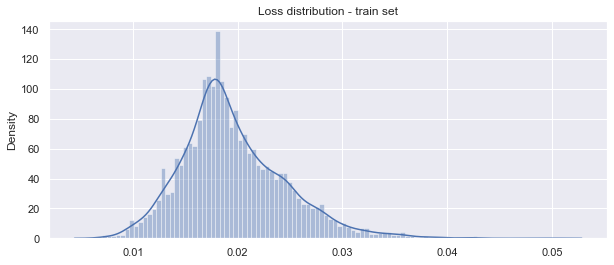

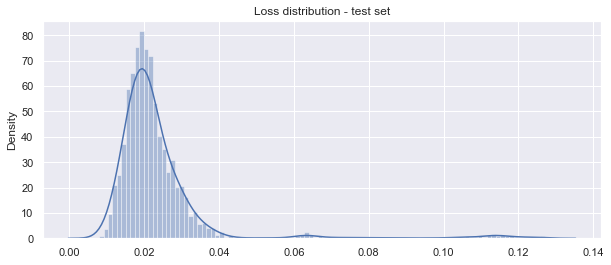

In [21]:
plt.title('Loss distribution - train set')
sns.distplot(train_mae_loss, bins=100, kde=True)
plt.show()

plt.title('Loss distribution - test set')
sns.distplot(test_mae_loss, bins=100, kde=True)
plt.show()

### Selection Threshold

threshold = mean of the loss + 2 standard devation of the loss

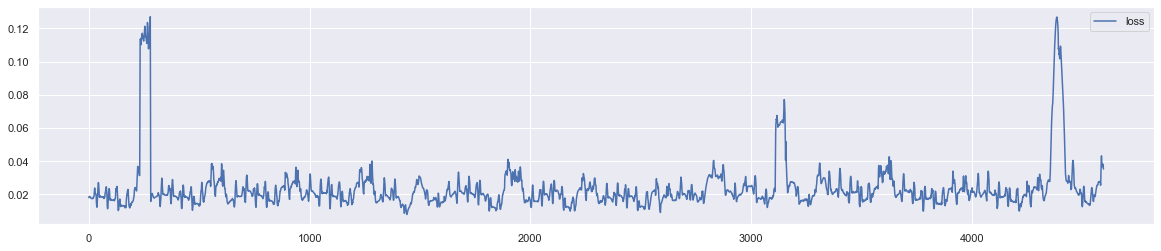

In [22]:
test_mae_loss_array = test_mae_loss.to_numpy().flatten()

plt.figure(figsize=(20,4))
plt.plot(test_mae_loss_array, label='loss')
plt.legend()
plt.show()

In [23]:
print(np.mean(test_mae_loss)[0] + 2 * np.std(test_mae_loss)[0])

0.05323975653718238


In [32]:
threshold = 0.05

### Loss for each window of the test set vs Threshold

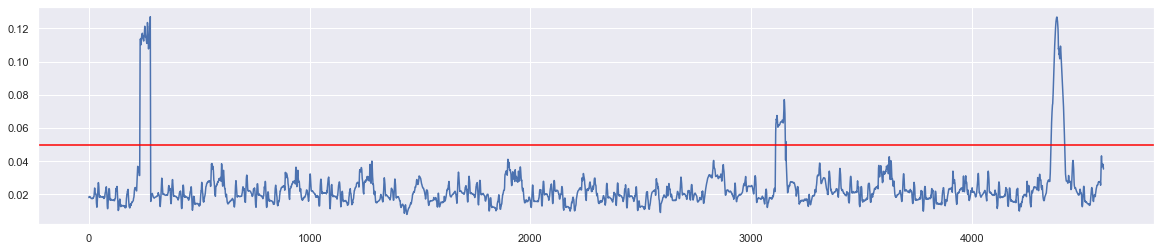

In [40]:
test_mae_loss_array = test_mae_loss.to_numpy().flatten()

plt.figure(figsize=(20,4))
plt.plot(test_mae_loss_array, label='loss')
plt.axhline(threshold, color='red', label='threshold')

### Dates where anomalies have been detected

In [34]:
y_pred = test_mae_loss_array >= threshold
y_pred.shape

(4597,)

In [35]:
dates_test[:-(window_length-1)].shape

(4597,)

In [36]:
dates_with_hours_anomalies = dates_test[:-(window_length-1)][y_pred]

print('Dates where anomalies have been detected:')
for d in dates_with_hours_anomalies:
    print(d)

Dates where anomalies have been detected:
2014-11-01 01:30:00
2014-11-01 02:00:00
2014-11-01 02:30:00
2014-11-01 03:00:00
2014-11-01 03:30:00
2014-11-01 04:00:00
2014-11-01 04:30:00
2014-11-01 05:00:00
2014-11-01 05:30:00
2014-11-01 06:00:00
2014-11-01 06:30:00
2014-11-01 07:00:00
2014-11-01 07:30:00
2014-11-01 08:00:00
2014-11-01 08:30:00
2014-11-01 09:00:00
2014-11-01 09:30:00
2014-11-01 10:00:00
2014-11-01 10:30:00
2014-11-01 11:00:00
2014-11-01 11:30:00
2014-11-01 12:00:00
2014-11-01 12:30:00
2014-11-01 13:00:00
2014-11-01 13:30:00
2014-11-01 14:00:00
2014-11-01 14:30:00
2014-11-01 15:00:00
2014-11-01 15:30:00
2014-11-01 16:00:00
2014-11-01 16:30:00
2014-11-01 17:00:00
2014-11-01 17:30:00
2014-11-01 18:00:00
2014-11-01 18:30:00
2014-11-01 19:00:00
2014-11-01 19:30:00
2014-11-01 20:00:00
2014-11-01 20:30:00
2014-11-01 21:00:00
2014-11-01 21:30:00
2014-11-01 22:00:00
2014-11-01 22:30:00
2014-11-01 23:00:00
2014-11-01 23:30:00
2014-11-02 00:00:00
2014-11-02 00:30:00
2014-11-02 01:00:0

In [37]:
indexes = []
for d in dates_with_hours_anomalies:
    index_low = np.where(dates_test == d)
    d_temp = d  + np.timedelta64(int(window_length / 2), 'h')
    indexes.append(index_low[0][0])

### Detected anomalies - plot

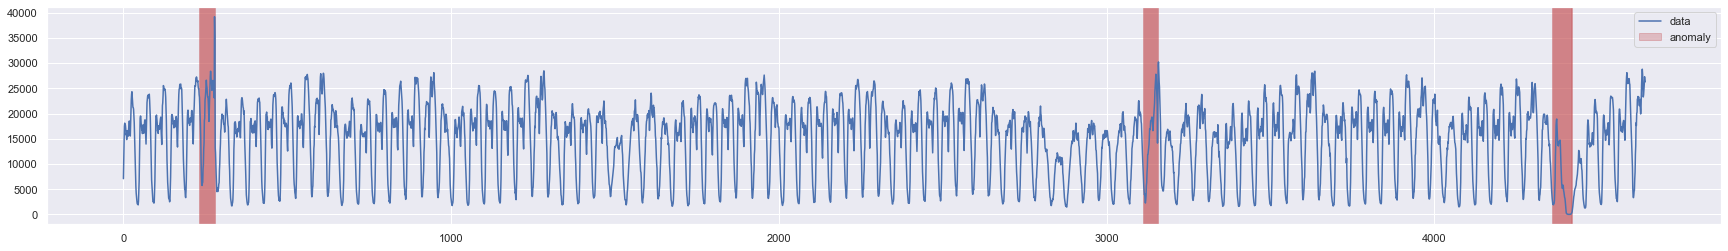

In [38]:
plt.figure(figsize=(30,4))
for index in indexes:
    plt.axvspan(index, index, color='r', alpha=0.3)
plt.plot(scaler.inverse_transform(test).flatten())
plt.legend(['data', 'anomaly'])
plt.show()